In [1]:
import datetime
import numpy

import pandas as pd
import seaborn as sns

## Summary

> This notebook adresses basic errors with the electricity consumption data: (i) **missing readings** and (ii) correction of **invalid measurements**. The process also outputs the following findings:
* Sensor read electricity consumption **every 30 secs**. 
* Sensor was **always-on** (i.e., sensor was never turn off, impling there were not power failures).
* Sensor **readings were lost** probably due to network related issues.
* Evidence suggest that there were **problems with the camera** reading values from the electricity meter.


## Dataset Characteristics

In [2]:
df = pd.read_csv("data/electricity.csv")

### Schema

In [3]:
df.head()

,Timestamp,Electricity
0,1514761710,664770
1,1514761890,664778
2,1514761920,664779
3,1514761950,664781
4,1514761980,664782


Timestamps are epoch based (in seconds). Electricity consumption values are probably kilowatt-hour (kWh).

### Empty Values

In [4]:
df.isnull().sum()

Timestamp      0
Electricity    0
dtype: int64

The original raw dataset does not contain empty values.

### Duration

In [5]:
start = datetime.datetime.fromtimestamp(df['Timestamp'].values[0] ) 
end   = datetime.datetime.fromtimestamp(df['Timestamp'].values[-1])

print('Start time: {}'.format(start))
print('End time:   {}'.format(end))

print('Duration:   {}'.format(end - start))

Start time: 2017-12-31 23:08:30
End time:   2019-02-27 22:59:00
Duration:   422 days, 23:50:30


Readings in the dataset span a period of 1 year, 57 days and 23hrs.

## Correction of  Electricity Consumption Values

### RAW dataset

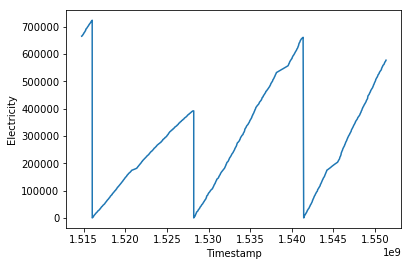

In [6]:
sns.lineplot(x='Timestamp', y='Electricity', data=df)

Note that **sensor reads electricity consumption incrementally**. This makes sense since the sensor was connected to a camera that read values directly from the electricity meter.

Also note that electricity consumption counter reset 3 times. This was probably due to problems related to the camera (e.g.,, camera not installed correctly, difficulties reading certain values, etc.). These errors have to be corrected.

### Errors detection

Recall that sensor reports electricity consumption incrementally. This means that there is an error when there is a negative difference between to consecutive readings.

In [7]:
# Add electricity consumption difference
df['diff_electricity'] = df['Electricity'].diff()

# Select readings where the difference is negative (errors)
sel = df['diff_electricity'] < 0
edf = df[ sel ]
edf

,Timestamp,Electricity,diff_electricity
28678,1516032300,25,-723211.0
278361,1528217940,1,-391579.0
278369,1528218390,1,-9.0
278371,1528218540,2,-2.0
278374,1528218660,1,-3.0
556782,1541421990,3,-660670.0
556837,1541424960,11,-107.0


In [8]:
print('Total num of errors:', len(edf.index))

Total num of errors: 7


There are in total **7 reading errors**: 
* 3 with important differences (those appearing in the plot above)
* 4 with minors differences

### Errors correction

Errors can be corrected by **adding the electricity difference** to all subsequent readings.

In [9]:
# For each error
for i in edf.index.values:
    # add the missing (absolute) diff_electricity to all subsquent readings
    n = df.shape[0]-1
    df.loc[i:n, 'Electricity'] += abs(df.loc[i, 'diff_electricity'])


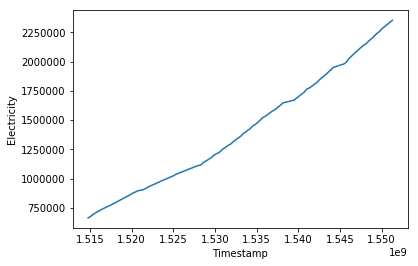

In [10]:
sns.lineplot(x='Timestamp', y='Electricity', data=df)

The data now reflect the increamental expected behaviour 👍

In [11]:
# Remove the extra column
del df['diff_electricity']

### Zero-Based Readings

For analytical purposes, it is better to have **zero-based energy consumption readings**. 

In [12]:
df['Electricity'] = df['Electricity'].diff()

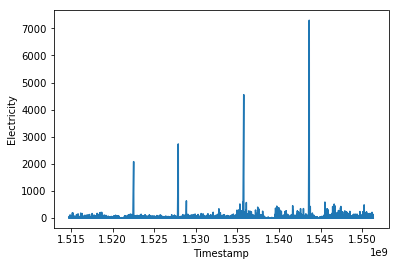

In [13]:
sns.lineplot(x='Timestamp', y='Electricity', data=df)

The peaks in the plot seem abnormal. This should be further explore in a different notebook. 

## Addressing Missing Readings 

### Sensing frequency

Sensors usually collect data at **frequent time intervals** (i.e., the time difference between two consecutive readings is constant).

In [14]:
df['Timestamp'].diff().value_counts().head(10)

30.0     514664
60.0     129645
90.0      44527
120.0     17948
150.0      8688
180.0      4962
210.0      3055
240.0      2046
270.0      1506
300.0      1116
Name: Timestamp, dtype: int64

As shown above, the most frequent interval in the dataset is 30. This means that the **sensor read electricity consumption every 30 secs**. 

### Identyfing missing readings

Note that several time intervals in the previous result are multiples of 30. This suggests that some **readings are missing**, probably due to wifi/bluetooth communication problems. 

In [15]:
df['timestamp_delta'] = df['Timestamp'].diff()
df.head(7)

,Timestamp,Electricity,timestamp_delta
0,1514761710,NaN,NaN
1,1514761890,8.0,180.0
2,1514761920,1.0,30.0
3,1514761950,2.0,30.0
4,1514761980,1.0,30.0
5,1514762010,1.0,30.0
6,1514762100,4.0,90.0


For instace, the `180` secs interval between readings `0` and `1` suggests that 5 readings are missing: T0+30, T0+60, T0+90, T0+120, T0+150. The same is true for readings `5` and `6`, where T5+30 is missing.

Let's see how many time intervals are multiples of 30:

In [16]:
# Time intervals
diff = df['Timestamp'].diff()

# Total number of time intervals
a = diff.value_counts().shape[0]

# Number of intervals multiple of 30
sel = diff.apply(lambda x: x%30==0 )
b   = diff[sel].value_counts().shape[0]

print('Total num of intervals:    {}'.format(a))
print('Intervals multiple of 30:  {}'.format(b))

Total num of intervals:    90
Intervals multiple of 30:  90


The fact that all intervals are multiple of 30 implies that sensor's internal clock never stop ticking (i.e., **sensor was always-on**). This finding also simplifies the process of inserting missing readings, since records have to be inserted every 30 secs right after the first reading in the dataset.

### Inserting missing readings

In pandas missing readings can be inserted by assigning a new index. Pandas automatically fills all empty values with `NaN`.

In [17]:
# Create an incremental index using timestamps as reference. The increment is 30 secs.
# https://stackoverflow.com/questions/25909984/missing-data-insert-rows-in-pandas-and-fill-with-nan
start = df['Timestamp'].values[0]   
end   = df['Timestamp'].values[-1] 
index = pd.Index( numpy.arange(start, end, 30), name="Timestamp")

# Replace the index with the one precomputed. Pandas automatically fills empty values with NaN
df = df.set_index("Timestamp").reindex(index).reset_index()
df.head(14)

,Timestamp,Electricity,timestamp_delta
0,1514761710,NaN,NaN
1,1514761740,NaN,NaN
2,1514761770,NaN,NaN
3,1514761800,NaN,NaN
4,1514761830,NaN,NaN
5,1514761860,NaN,NaN
6,1514761890,8.0,180.0
7,1514761920,1.0,30.0
8,1514761950,2.0,30.0
9,1514761980,1.0,30.0


In [18]:
df.isnull().sum()

Timestamp               0
Electricity        485031
timestamp_delta    485031
dtype: int64

Note that missing readings are now represented in the dataset (~485K). Their analysis should be addressed in a separate notebook.

In [19]:
# Remove extra column
del df['timestamp_delta']

## Storage

At this point, the data is cleaned and can be store into a file:

In [21]:
df.to_csv('data/cleaned/electricity-cleaned.csv', index=False)